In [190]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e2/sample_submission.csv
/kaggle/input/playground-series-s4e2/train.csv
/kaggle/input/playground-series-s4e2/test.csv


In [191]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import RMSprop, Adam

In [192]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## データの確認

In [193]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e2/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e2/test.csv')

display(df_train.head())
display(df_test.head())

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [194]:
print('Train: ')
print(df_train.isnull().sum())
print('\n')
print('Test: ')
print(df_test.isnull().sum())

Train: 
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


Test: 
id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               

欠損値はない

In [195]:
print(df_train.info(),df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

## 数値データのカテゴリデータの分類

In [196]:
df_train = df_train.drop('id',axis=1)
numerical_columns = df_train.select_dtypes(include=['float64', 'int64'])
object_columns = df_train.select_dtypes(include=['object'])

## カテゴリデータの前処理

In [197]:
def plot_category_distribution(data, category_field):
    """
    データフレームの指定されたカテゴリフィールドに基づいて円グラフと棒グラフを作成する関数。

    Parameters:
    - data: データフレーム
    - category_field: カテゴリフィールドの列名

    Returns:
    - None (グラフが表示されます)
    """

    # カテゴリごとのデータ数を取得
    category_counts = data[category_field].value_counts()

    # 円グラフの作成
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'{category_field} Distribution')

    # 棒グラフの作成
    plt.subplot(1, 2, 2)
    category_counts.plot(kind='bar', color='skyblue')
    plt.xlabel(category_field)
    plt.ylabel('Count')
    plt.title(f'{category_field} Counts')

    # グラフを表示
    plt.tight_layout()
    plt.show()

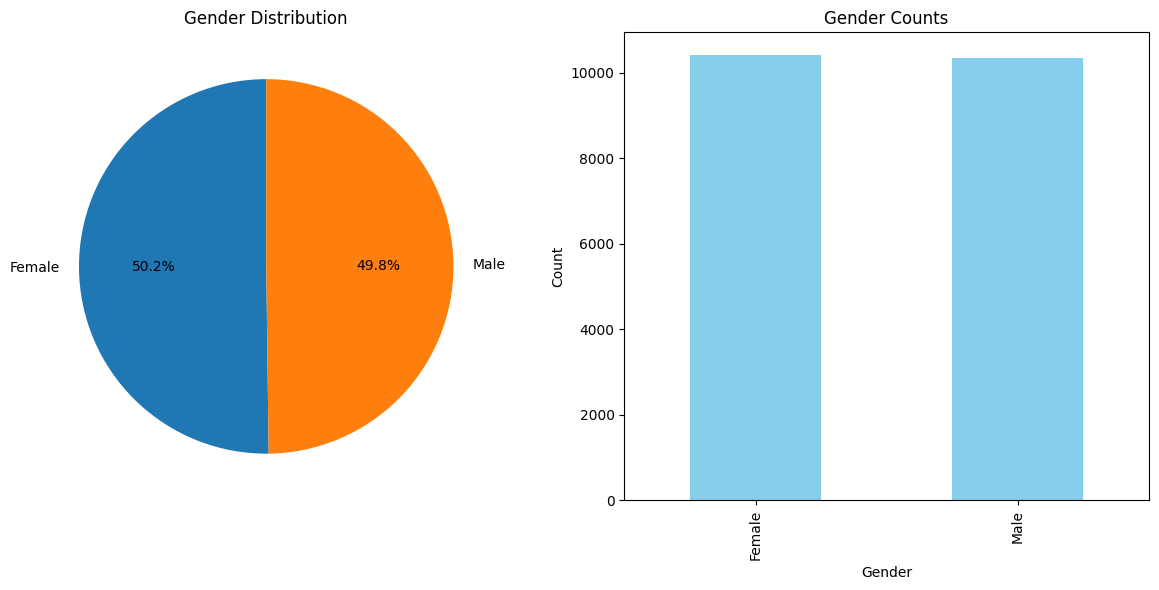

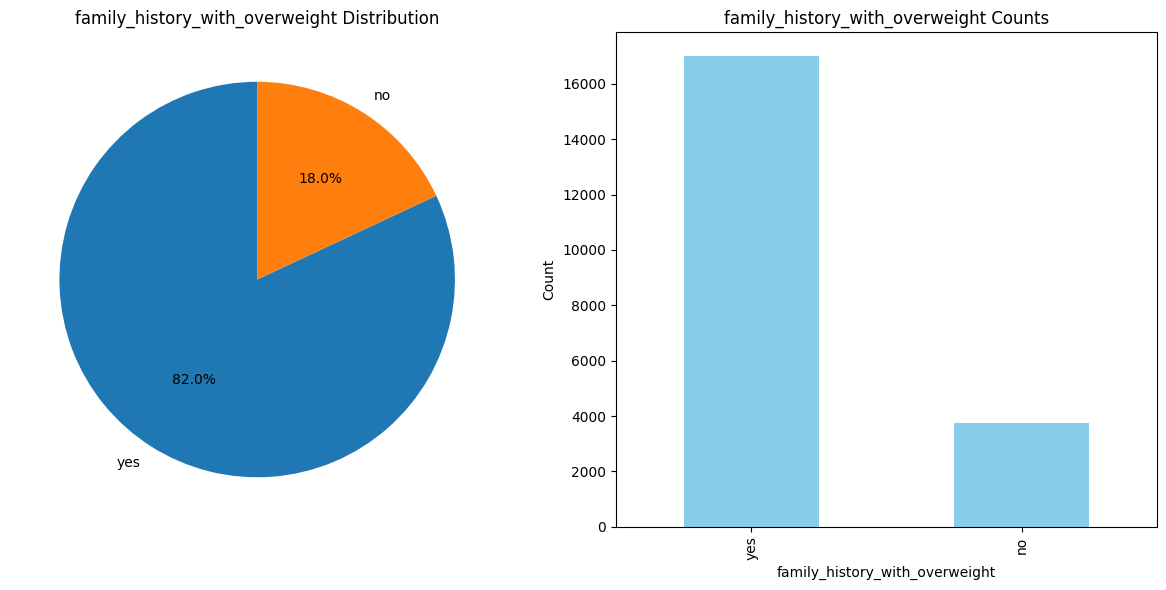

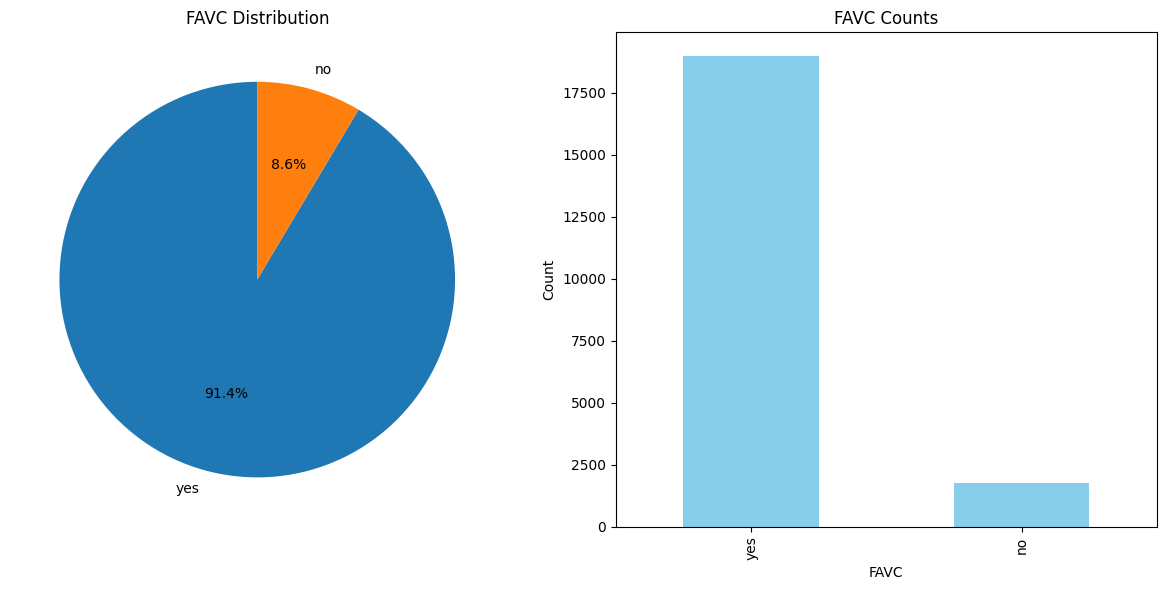

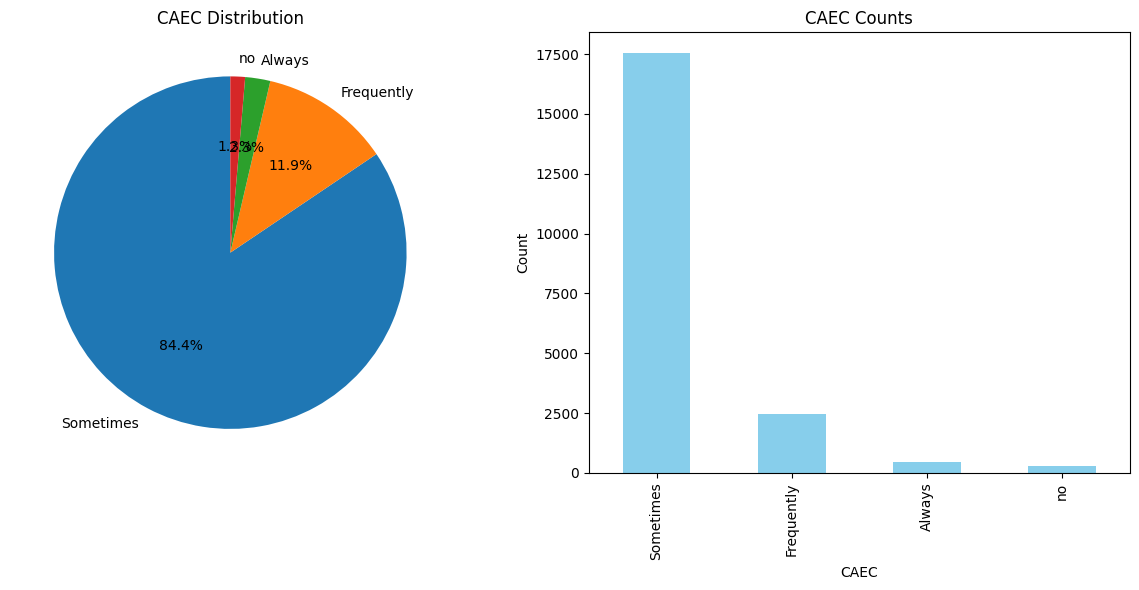

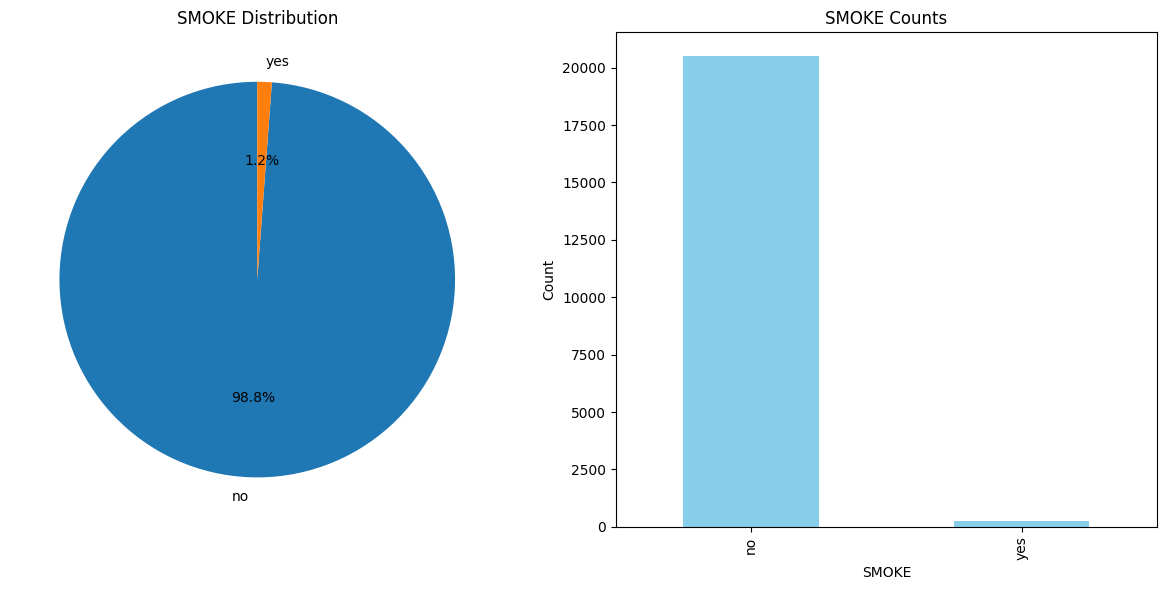

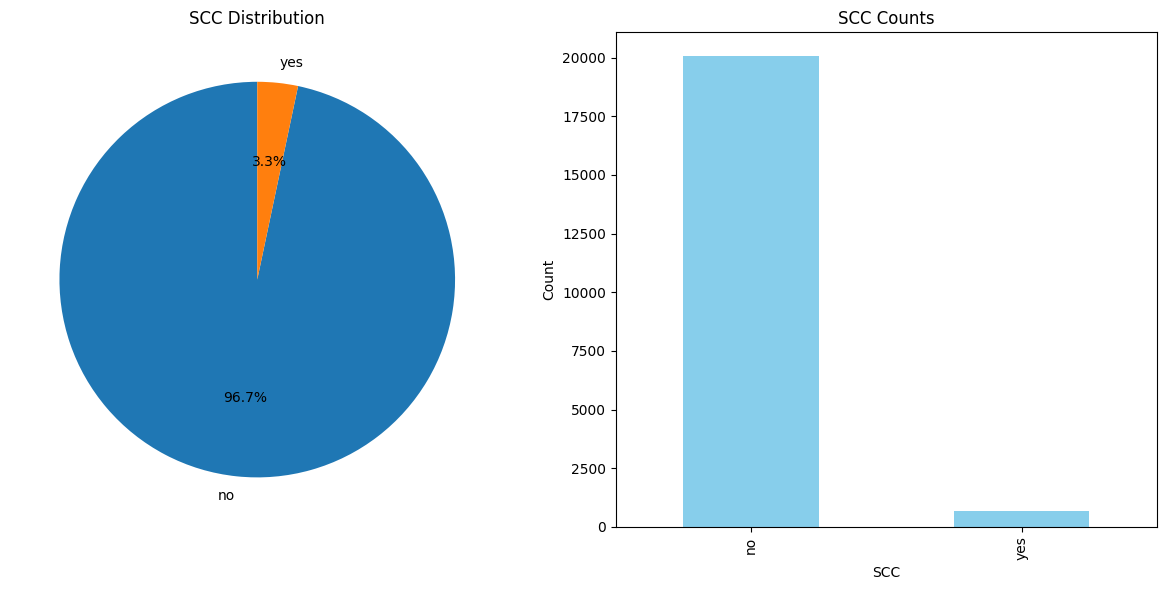

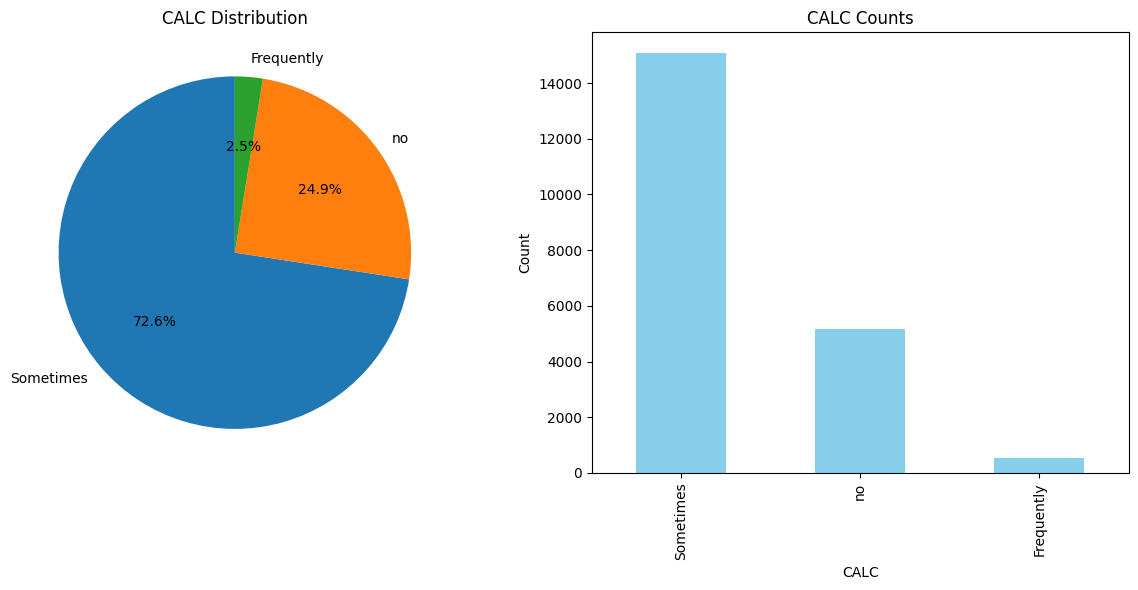

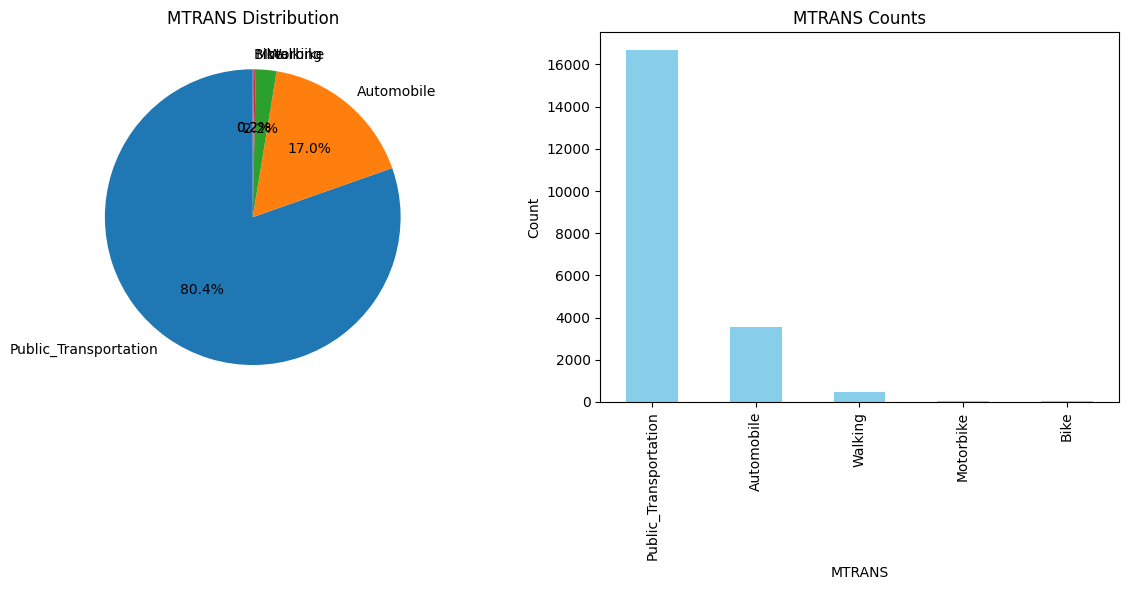

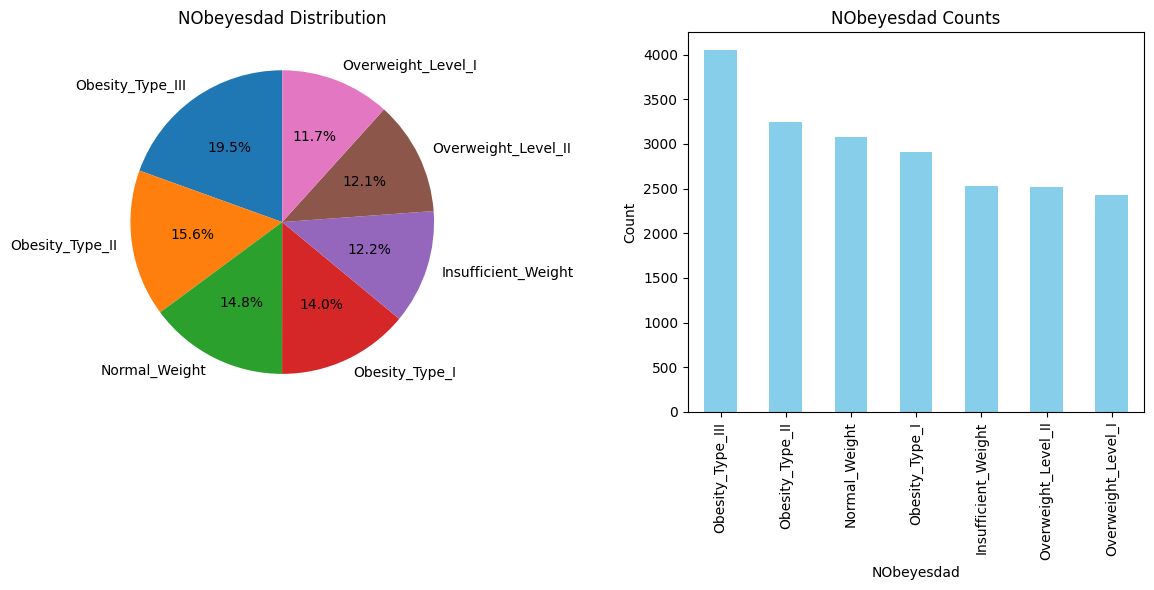

In [198]:
# 関数を呼び出してグラフを表示
for column in object_columns.columns:
    plot_category_distribution(object_columns, column)

### binary columnsのエンコーディング

In [199]:
binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']

for col in binary_cols:
    df_train[col] = df_train[col].map({'yes': 1, 'no': 0})
    
df_train['Gender'] = df_train['Gender'].map({'Male':1,'Female':0})
    
df_train.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,Sometimes,0,2.763573,0,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,Frequently,0,2.000000,0,1.000000,1.000000,no,Automobile,Normal_Weight
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,Sometimes,0,1.910378,0,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,Sometimes,0,1.674061,0,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,Sometimes,0,1.979848,0,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


### 順番が関係するobject columnsのエンコーディング

In [200]:
df_train['CAEC'] = df_train['CAEC'].map({
    'no': 0,
    'Always': 3,
    'Frequently': 2,
    'Sometimes': 1
})

df_train['CALC'] = df_train['CALC'].map({
    'no': 0,
    'Frequently': 2,
    'Sometimes': 1
})

df_train[['CAEC', 'CALC']].head()

,CAEC,CALC
0,1,1
1,2,0
2,1,0
3,1,1
4,1,1


### ラベルの重みを決定

In [201]:
transport_mapping = {
    'Bike': 2,
    'Walking': 2,
    'Public_Transportation': 1,
    'Automobile': 0,
    'Motorbike': 0,
}

df_train['MTRANS'] = df_train['MTRANS'].map(transport_mapping)

# Check the results
print(df_train['MTRANS'].value_counts())
df_train.head()

MTRANS
1    16687
0     3572
2      499
Name: count, dtype: int64


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,1,24.443011,1.699998,81.669950,1,1,2.000000,2.983297,1,0,2.763573,0,0.000000,0.976473,1,1,Overweight_Level_II
1,0,18.000000,1.560000,57.000000,1,1,2.000000,3.000000,2,0,2.000000,0,1.000000,1.000000,0,0,Normal_Weight
2,0,18.000000,1.711460,50.165754,1,1,1.880534,1.411685,1,0,1.910378,0,0.866045,1.673584,0,1,Insufficient_Weight
3,0,20.952737,1.710730,131.274851,1,1,3.000000,3.000000,1,0,1.674061,0,1.467863,0.780199,1,1,Obesity_Type_III
4,1,31.641081,1.914186,93.798055,1,1,2.679664,1.971472,1,0,1.979848,0,1.967973,0.931721,1,1,Overweight_Level_II


目的データのラベリング

## 数値データの可視化

In [202]:
# sns.pairplot(numerical_columns)
# plt.show()

<Axes: >

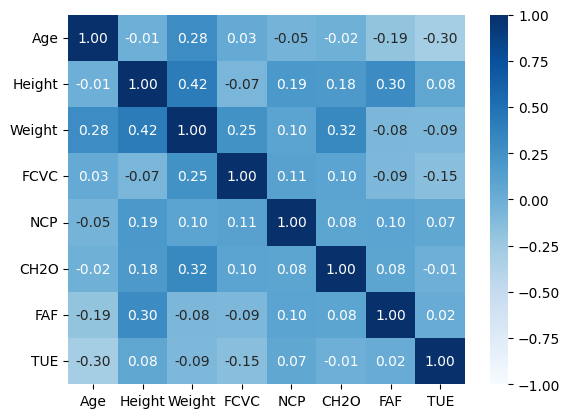

In [203]:
cor = numerical_columns.corr()
sns.heatmap(cor, cmap= 'Blues', annot=True,fmt='.2f', vmin = -1, vmax = 1)

In [204]:

def plot_numeric_fields(data):
    """
    データフレーム内の数値フィールドすべてに対してヒストグラムと密度関数を可視化する関数。

    Parameters:
    - data: データフレーム

    Returns:
    - None (グラフが表示されます)
    """

    # データフレームから数値フィールドを取得
    numeric_fields = data.columns
    plt.figure(figsize=(12, 6))

    # ヒストグラムと密度関数の描画
    for i , field in enumerate(numeric_fields):
    
        # ヒストグラム　Kernel密度関数
        plt.subplot(3, 4, i+1)
        sns.histplot(data[field], kde=True, bins=20)
        plt.title(f'{field} Histogram')

        # グラフを表示
        plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

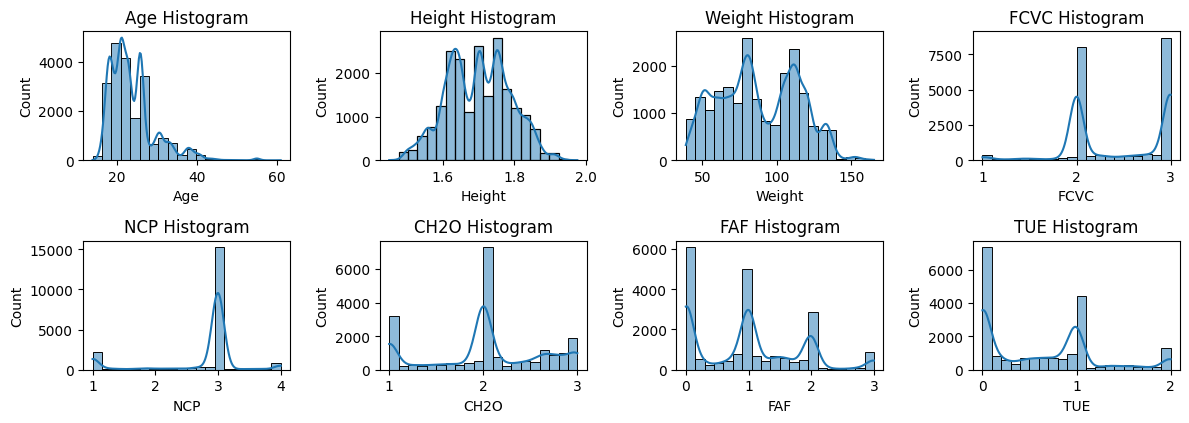

In [205]:
plot_numeric_fields(numerical_columns)

## 特徴量エンジニアリング
ここではBMI $$ BMI = \frac{Weight}{Height^2} $$で定義されるBMIを特徴量として追加する。

In [206]:
df_train['BMI'] = df_train['Weight'] / df_train['Height']**2
df_train[['Weight', 'Height', 'BMI']].head()

,Weight,Height,BMI
0,81.669950,1.699998,28.259565
1,57.000000,1.560000,23.422091
2,50.165754,1.711460,17.126706
3,131.274851,1.710730,44.855798
4,93.798055,1.914186,25.599151


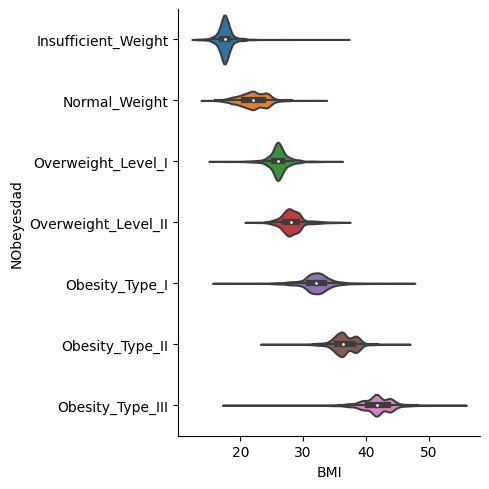

In [207]:
order = df_train.groupby('NObeyesdad')['BMI'].mean().sort_values().index
sns.catplot(x='BMI', y='NObeyesdad', data=df_train, kind='violin', order=order)
plt.show()

In [208]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

In [209]:
numerical_columns['BMI'] = df_train['BMI']

In [211]:
power_transformer = PowerTransformer(method='box-cox')
df_train[numerical_columns.columns] = power_transformer.fit_transform(df_train[numerical_columns.columns]+1)
scaler = StandardScaler()
df_train[numerical_columns.columns] = scaler.fit_transform(df_train[numerical_columns.columns])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

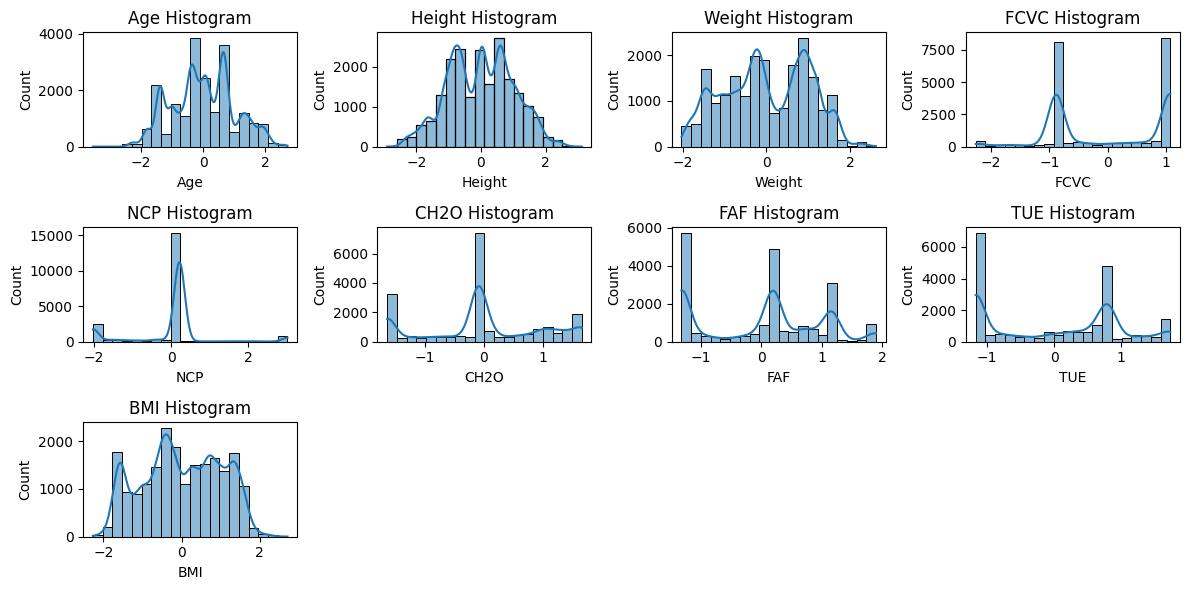

In [212]:
plot_numeric_fields(df_train[numerical_columns.columns])

In [213]:
# df_train[numerical_columns.columns].head

In [214]:
target_mapping = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

df_train['NObeyesdad'] = df_train['NObeyesdad'].map(target_mapping)

# Check the results
print(df_train['NObeyesdad'].value_counts())
df_train.head()

NObeyesdad
6    4046
5    3248
1    3082
4    2910
0    2523
3    2522
2    2427
Name: count, dtype: int64


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,BMI
0,1,0.392274,0.001826,-0.180944,1,1,-0.882621,0.182365,1,0,1.232230,0,-1.320341,0.775163,1,1,3,-0.195655
1,0,-1.379784,-1.613755,-1.189908,1,1,-0.882621,0.217247,2,0,-0.084861,0,0.200903,0.804524,0,0,1,-0.799525
2,0,-1.379784,0.133016,-1.495630,1,1,-1.077494,-1.817734,1,0,-0.232407,0,0.041157,1.483281,0,1,0,-1.645399
3,0,-0.403279,0.124665,1.562234,1,1,1.072753,0.217247,1,0,-0.613803,0,0.696094,0.509587,1,1,6,1.674900
4,1,1.384082,2.427755,0.274031,1,1,0.383134,-1.357225,1,0,-0.118174,0,1.144539,0.717945,1,1,3,-0.523527


# Pytorch

In [215]:
# Set random seed
torch.manual_seed(14)
np.random.seed(14)

In [216]:
X = np.array(df_train.drop(['NObeyesdad'], axis=1))
y = np.array(df_train['NObeyesdad']) 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=14)

In [217]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((16606, 17), (4152, 17), (16606,), (4152,))

In [218]:
# 型変換
X_train = torch.FloatTensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.LongTensor(y_val)

In [219]:
# データセット
train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)

In [220]:
# データローダー
train_loader = DataLoader(train, batch_size=3000, shuffle=True)
val_loader = DataLoader(val, batch_size=1000, shuffle=False)

In [221]:
class MultiClassNet(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.lin1 = nn.Linear(num_features, 512)
#         self.lin2 = nn.Linear(512, 512)
        self.lin3 = nn.Linear(512, 256)
        self.lin4 = nn.Linear(256, 128)
        self.lin6 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.bn3 = nn.BatchNorm1d(256)
        self.bn4 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.lin2(x)
#         x = self.bn2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
        x = self.lin3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.lin4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.lin6(x)
        return x       

In [222]:
num_epochs = 400
NUM_FEATURES = X_train.shape[1]
N_CLASSES = len(y_train.unique())
N_CLASSES, NUM_FEATURES

(7, 17)

In [223]:
model = MultiClassNet(NUM_FEATURES, N_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=0.0001)
model

MultiClassNet(
  (lin1): Linear(in_features=17, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=256, bias=True)
  (lin4): Linear(in_features=256, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_features=7, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [224]:
def train(train_loader):
  model.train()
  running_loss = 0
  for batch_idx, (features, labels) in enumerate(train_loader):
    features = features.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    outputs = model(features)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_loss = running_loss / len(train_loader)
  return train_loss

def valid(val_loader):
  model.eval()
  running_loss = 0
  correct = 0
  total = 0
  with torch.no_grad():
    for batch_idx, (features, labels) in enumerate(val_loader):
      features = features.to(device)
      labels = labels.to(device)
      outputs = model(features)
      loss = criterion(outputs, labels)
      running_loss += loss.item()
      predicted = outputs.max(1, keepdim=True)[1]
      correct += predicted.eq(labels.view_as(predicted)).sum().item() # ここで精度を計算
      total += labels.size(0)
  val_loss = running_loss / len(val_loader)
  val_acc = correct / total
  return val_loss, val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
  loss = train(train_loader)
  val_loss, val_acc = valid(val_loader)
  if epoch % 50 == 0:
      print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))
  # logging
  loss_list.append(loss)
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss, val_loss, val_acc))

epoch 0, loss: 1.9289 val_loss: 1.9081 val_acc: 0.1775
epoch 50, loss: 0.4940 val_loss: 0.4381 val_acc: 0.8533
epoch 100, loss: 0.3888 val_loss: 0.3586 val_acc: 0.8702
epoch 150, loss: 0.3558 val_loss: 0.3449 val_acc: 0.8752
epoch 200, loss: 0.3311 val_loss: 0.3406 val_acc: 0.8810
epoch 250, loss: 0.3182 val_loss: 0.3406 val_acc: 0.8813
epoch 300, loss: 0.3026 val_loss: 0.3411 val_acc: 0.8815
epoch 350, loss: 0.2885 val_loss: 0.3466 val_acc: 0.8829
epoch 399, loss: 0.2812 val_loss: 0.3478 val_acc: 0.8813


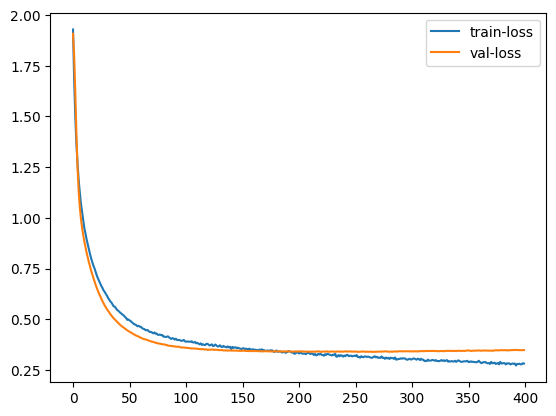

In [225]:
plt.plot(loss_list, label='train-loss')
plt.plot(val_loss_list, label='val-loss')
plt.legend()
plt.show()